In [7]:
import pandas as pd
import numpy as np

n_participants = 1000
age_min = 3
age_max = 60
data = pd.DataFrame(data={'group': np.random.randint(0, 2, n_participants),
                          'age': ((age_min+np.random.rand(n_participants)*(age_max-age_min))*365).astype(int),
                          'score': np.random.randn(n_participants)})
data.group = data.group.replace({0:'CTR', 1: 'PROB'})
data.loc[data.group == 'PROB', 'score'] = data.loc[data.group == 'PROB', 'score'] * 1.5
data.head()

,group,age,score
0,CTR,9520,-0.846355
1,PROB,19108,2.775389
2,CTR,17898,-0.703674
3,PROB,7423,0.509193
4,PROB,6564,-1.560729


In [8]:
from PyNM import PyNM

# Description of the PyNM output
- **data**: dataframe with normative models computed
- **x**: age bins
- **xcount**: number of CTR participants (per bin)
- **z**: estimated centiles (per bin)
- **zm**: estimated mean (per bin)
- **zstd**: estimated standard deviation (per bin)
- **zci**: 95% confidence interval (per bin)

In [9]:
data, x, xcount, z, zm, zstd, zci = PyNM(data)
data.head()

,group,age,score,participants,LOESS_nmodel,LOESS_rank,Centiles_nmodel,Centiles_rank
0,CTR,9520,-0.846355,22.0,-0.791967,0.0,21,-1.0
1,PROB,19108,2.775389,24.0,2.886975,2.0,100,2.0
2,CTR,17898,-0.703674,25.0,-1.051082,-1.0,15,-1.0
3,PROB,7423,0.509193,29.0,0.264334,0.0,67,0.0
4,PROB,6564,-1.560729,28.0,-1.989594,-1.0,0,-2.0


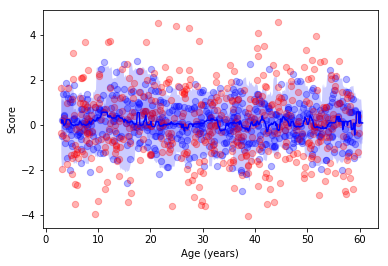

In [10]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(data.loc[data.group == 'CTR', :].age.values / 365,
            data.loc[data.group == 'CTR', :].score.values,
            s=40,
            color='b', alpha=0.3)
plt.plot(x / 365, z[:, 50], '-', color='b')
plt.fill_between(x / 365,
                    z[:, 5],
                    z[:, 95],
                    facecolor='blue',
                    alpha=0.2,
                    zorder=1)
plt.fill_between(x / 365,
                    z[:, 25],
                    z[:, 75],
                    facecolor='blue',
                    alpha=0.2,
                    zorder=2)
plt.scatter(data.loc[data.group == 'PROB', :].age.values / 365,
            data.loc[data.group == 'PROB', :].score.values,
            s=40,
            color='r', alpha=0.3)

for bin_sel in np.argwhere((xcount <= 20) + (xcount <= 20)).flatten():
    plt.plot(np.array([x[bin_sel], x[bin_sel]]) / 365,
                [z.min() - 1, z.max() + 1], '--k', alpha=0.5)

plt.ylabel('Score')
plt.xlabel('Age (years)')
plt.show()

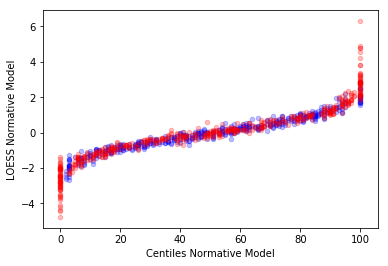

In [11]:
plt.figure()
plt.scatter(data.loc[data.group == 'CTR', 'Centiles_nmodel'],
            data.loc[data.group == 'CTR', 'LOESS_nmodel'],
            s=20, color="blue", alpha=0.25)
plt.scatter(data.loc[data.group == 'PROB', 'Centiles_nmodel'],
            data.loc[data.group == 'PROB', 'LOESS_nmodel'],
            s=20, color="red", alpha=0.25)
plt.xlabel('Centiles Normative Model')
plt.ylabel('LOESS Normative Model')
plt.show()

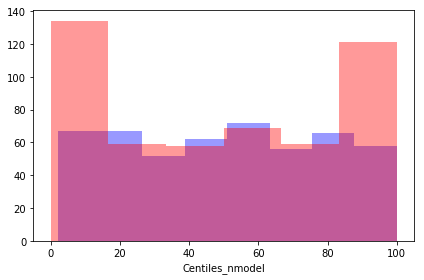

In [12]:
import seaborn as sns
plt.figure()
fig = sns.distplot(data.loc[data.group == 'CTR', 'Centiles_nmodel'],
                    color="blue", kde=False)
fig = sns.distplot(data.loc[data.group == 'PROB', 'Centiles_nmodel'],
                    color="red", kde=False)
plt.tight_layout()
plt.show()